# Classification of Images using CNN


- Torch is main pytorch module. 
- The `nn` module contains things like layer definitions, activations, loss functions etc.
- The helper module `functional` provides almost same functionality as the `nn` module. Don't need to initialize object for activation function.
- The `optim` module contains the hyper-optimizers
- `torchvision` is the computer vision module of pytorch.

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F    
import torch.optim as optim
from torchvision import datasets, transforms

### Define the model

- A simpler albeit less common way is the `Sequential()` way => define what layers your NN has.

#### Pseudocode
1. `import torch.nn as nn`
2. Define the no. of units in each layer. e.g.
   | Layer | No. of units / nodes / neurons |
   |---|---|
   | Input | 10 |
   | Hidden | 5 |
   | Output | 1 |

3. Load the data
4. Define the model

   ```python
   model = nn.Sequential(
                  nn.Linear(10, 5),
                  nn.ReLU(),
                  nn.Linear(5, 1),
                  nn.Sigmoid()
            )
   ```
5. Define the `loss` function.
   ```python
   MSE = nn.MSELoss()
   ```

6. Optimization Algorithm
   ```python
   optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
   ```
----

- **However**, in Pytorch, to define the neural network model, you have to define class e.g. `Net`. It has to inherit from the `nn` module.
- This is applicable to more complex NNs.


In [2]:
class Net(nn.Module):

    """
    - the __init__() constructor is called whenever we create instance of the `nn.Module`
    - here we define no. of layers, neurons, hidden layers
    - for CNNs, we alsod define kernel sizes, probability of dropout layer
    """
    def __init__(self):
        """
        Challenge with `__init__`:
        
        When creating a subclass, you might want to call the parent class's `__init__ `
        function to initialize its attributes before adding your own customizations 
        in the subclass's `__init__`.
        
        Simply using ParentClass.`__init__(self)` within the subclass's `__init__` can 
        lead to issues, especially with multiple levels of inheritance (more than one 
        parent class).

        Solution: `super()`
        `super()` is a built-in function that helps you call the appropriate `__init__` 
        method from the parent class in a robust way.
        """
        super(Net, self).__init__()
        """
        - We have 4 layers: 2 convolutional and 2 fully connected (FC)
        - First Conv layer accepts single 2D image and outputs 20 different matrices. The shape 
        of the output matrix depends on shape of kernel. That's 5x5 kernel in 3rd parameter
        """
        self.conv1 = nn.Conv2d(1, 20, 5)
        
        """
        - Second Conv layer has same definition. 20 input features from output of previous layer.
        Output 50 different features. And kernel size is 5x5. Output of the second conv. layer 
        when fed into 1st FC layer will be 50 channels and matrix size is 4x4.
        """
        self.conv2 = nn.Conv2d(20, 50, 5)
        
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)
        # self.fc3 = nn.Linear(1000, 10)


    """
    - in `forward()`, we define how the output will be computed.
    - In Pytorch, if you define forward pass through network, then it uses `autograd` 
    library to automatically calculate the backward pass.
    - it takes `x` vector or tensor as input.
    - the vector is of size 784 at the beginning.
    """
    def forward(self, x):
        x = F.relu(self.conv1(x)) # ReLU applied to output of first conv layer

        """
        max pooling function to output of previous step i.e. x. It looks at matrices
        of size 2x2 and move 2 pixels at a time.
        """
        x = F.max_pool2d(x, 2, 2)

        # do exact the same for conv layer 2
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        
        """
        # x.view(<batch-size>, 784). 
        # When batch-size = -1 => you don't care about the batch size.
        # flatten the layers to one flat tensor of 800 neurons
        """
        x = x.view(-1, 4*4*50)   
        
        """
        # fc layer 1 is connected to input vector. 
        # And ReLU non linear activation function is applied to it.
        """
        x = F.relu(self.fc1(x))  
        x = self.fc2(x)  # do the same but for layer two.
        # x = self.fc3(x)          # don't apply AF here. Only Linear function

        """
        - logarithmic softmax function applied here. Output of network isn't of size 10
        where every value = probability
        - softmax value which has highest probability.
        """
        return F.log_softmax(x, dim=1)  

## Loading the data

- We use `DataLoader` and `DataSet` `torch` `util` classes
- The training and testing will stay pretty much the same as previous example, until you get to the more advanced models.

In [3]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data',                   
                   # train parameter here decides whether the dataset is training 
                   # or testing as per the boolean flag                  
                   train=True, 
                   download=True,
                   # the downloaded data is in PIL format. We want to make it into Tensor.
                   transform=transforms.Compose([
                       transforms.ToTensor(), 
                       transforms.Normalize((0.1307,),(0.3081,))
                    ])),
                    # shuffle set as True to make results generic
                    batch_size=128, shuffle=True  
                )

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', 
                   train=False, 
                   download=True, 
                   transform=transforms.Compose([
                       transforms.ToTensor(), 
                       transforms.Normalize((0.1307,),(0.3081,))
                    ])),
                    batch_size=1000, shuffle=True
                )


## Training and testing loops

- Boiler plate code for training and testing.
- Most ML Frameworks don't expose this part of code.
- However since PyTorch framework is used for experimental research, you have full control over how a model is trained/tested.

In [4]:
"""
the train() accepts the 
    neural network `model`, 
    the `device` on which to run it, 
    the `train_loader` training dataset, epoch and optimizer
"""
def train(model, device, train_loader, optimizer, epoch):
    model.train()   # biases in the model can be changed.

    # running with enum, coz wanna know batch index current loss
    for batch_idx, (data, target) in enumerate(train_loader): 
        # move data and target to the device e.g. graphics card. edge programming 
        data, target = data.to(device), target.to(device)   
        optimizer.zero_grad()  # set up fresh calculations
        output = model(data)   # running data through fwd pass and get output at current step

        # loss at curr. step using negative log likelihood loss coz it works well 
        # for softmax output
        loss = F.nll_loss(output, target)

        # PyTorch feature. By doing back-propagation through network, can be done automatically.
        loss.backward()    
        optimizer.step()   # changes the parameters in the network
        if batch_idx%100 == 0:
            # print every 100 batches
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx*len(data), len(train_loader.dataset), 100.*batch_idx/len(train_loader), loss.item()
            ))

In [5]:
def test(model, device, test_loader):
    model.eval()   # model during eval mode will NOT change parameters
    test_loss = 0
    correct = 0    # we count how many test sets got correct
    with torch.no_grad():  # speeds up the process. We tell don't remeber gradients so make faster processing
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)   # running the data through the model

            # since we're testing in batch, we're interested in only sum of all losses in the batch
            test_loss += F.nll_loss(output, target, reduction='sum').item()

            # get index of maxiumum o/p probability from the o/p vector
            pred = output.argmax(dim=1, keepdim=True)   

            # count how many samples we got correct/incorrect. 
            # Compare the correct labels in batch and sum them up.
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)

    print('\nTest Set: Average Loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset), 100.*correct/len(test_loader.dataset)
    ))

## Running the Model

In [6]:
use_cuda = torch.cuda.is_available()

torch.manual_seed(42) # for reproducible results, set random weight

device = torch.device("cuda" if use_cuda else "mps") # PyTorch added support for M1 GPU on May 2022

model = Net().to(device)  # Move the model to the device.
"""
- We've to tell it what it is optimizing. 
- A helper method parameters() can be called in any neural network model in PyTorch
- It calls all the params based on the fwd function.
"""
optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.5) 

# test before training

for epoch in range(1, 3+1):  # train for 3 epochs, and test after running each epoch.
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

torch.save(model.state_dict(), "mnist.pt")  # save the model to `mnist.pt`


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.297693
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.172063
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.131213
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.026413
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.081763

Test Set: Average Loss: 0.0615, Accuracy: 9794/10000 (98%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.062588
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.045184
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.088043
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.043429
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.050045

Test Set: Average Loss: 0.0422, Accuracy: 9849/10000 (98%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.044380
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.081854
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.015940
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.048186
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.067345

Test Set: Average Loss: 0.0329, Accuracy: 9894/10000 (99%)



## Testing the Model

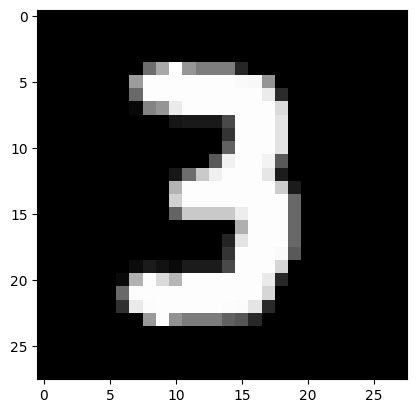

In [8]:
import matplotlib.pyplot as plt

test_image = test_loader.dataset.data[8080]
plt.imshow(test_image, cmap='gray')

In [9]:
# RUN THE IMAGE THROUGH MODEL
#out = model(test_image.view(1, 1, 28, 28).float().cuda()))  <--- for CUDA support

"""
we re-shape the input to the network to a tensor of 4 dimensions
1 => no. of images in batch
1 => no. of channels. Here it's grayscale, therefore 1. For RGB, it'll be 3.
28, 28 => size of the image
"""
out = model(test_image.view(1, 1, 28, 28).float().to(torch.device('mps')))  # <--- for Mac M1 GPUs
out

tensor([[-1848.5481, -1359.6426, -1290.8562,     0.0000, -1820.7024, -1367.5131,
         -2498.4868, -1442.9772, -1343.4097, -1162.1522]], device='mps:0',
       grad_fn=<LogSoftmaxBackward0>)

in above output, all values in the 10 unit vector output are negative or zero except for the index value.

In [10]:
out.argmax(dim=1)

tensor([3], device='mps:0')

## More PyTorch models

- You may have noticed that we typically defined our models ourselves e.g. in `Net()` class above.
- But PyTorch has many more widely known models as stated below, which are already trained aka pre-trained.
- So we need not train them separately. 

In [17]:
import torchvision.models
dir(models)

['AlexNet',
 'AlexNet_Weights',
 'ConvNeXt',
 'ConvNeXt_Base_Weights',
 'ConvNeXt_Large_Weights',
 'ConvNeXt_Small_Weights',
 'ConvNeXt_Tiny_Weights',
 'DenseNet',
 'DenseNet121_Weights',
 'DenseNet161_Weights',
 'DenseNet169_Weights',
 'DenseNet201_Weights',
 'EfficientNet',
 'EfficientNet_B0_Weights',
 'EfficientNet_B1_Weights',
 'EfficientNet_B2_Weights',
 'EfficientNet_B3_Weights',
 'EfficientNet_B4_Weights',
 'EfficientNet_B5_Weights',
 'EfficientNet_B6_Weights',
 'EfficientNet_B7_Weights',
 'EfficientNet_V2_L_Weights',
 'EfficientNet_V2_M_Weights',
 'EfficientNet_V2_S_Weights',
 'GoogLeNet',
 'GoogLeNetOutputs',
 'GoogLeNet_Weights',
 'Inception3',
 'InceptionOutputs',
 'Inception_V3_Weights',
 'MNASNet',
 'MNASNet0_5_Weights',
 'MNASNet0_75_Weights',
 'MNASNet1_0_Weights',
 'MNASNet1_3_Weights',
 'MaxVit',
 'MaxVit_T_Weights',
 'MobileNetV2',
 'MobileNetV3',
 'MobileNet_V2_Weights',
 'MobileNet_V3_Large_Weights',
 'MobileNet_V3_Small_Weights',
 'RegNet',
 'RegNet_X_16GF_Weights'